## 1. Augmentation을 적용한 데이터셋 만들기
---
- 데이터셋에 CutMix 또는 Mixup augmentation을 적용하기

### 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

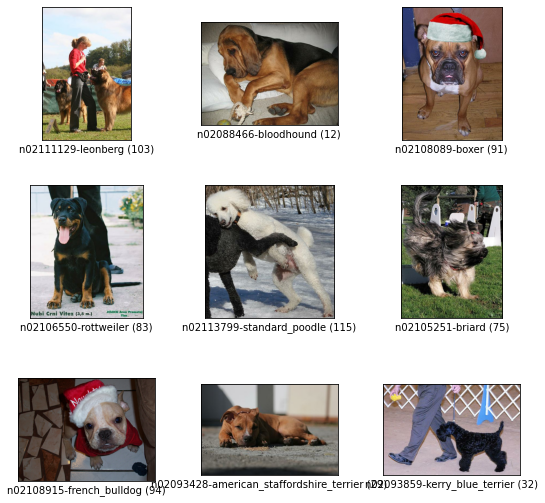

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

### Augmentation 적용하기

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224,224])
    return tf.cast(image, tf.float32) / 255. , label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, INPUT_SHAPE)
    return image, label

In [9]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [10]:
ds_train_dummy = apply_normalize_on_dataset(ds_train)

### 심화기법: Cutmix

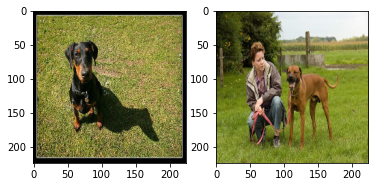

In [11]:
for i, (image, label) in enumerate(ds_train_dummy.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [12]:
def get_clip_box(image_a, image_b, img_size=224):
    x = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    
    _prob = tf.random.uniform([], 0, 1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob), tf.int32)
    
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(87, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(117, shape=(), dtype=int32)


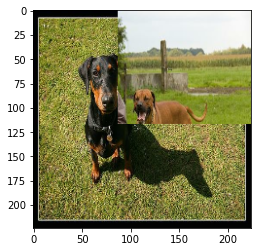

In [13]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb, 0:xa, :]
    two = image_b[ya:yb, xa:xb, :]
    three = image_a[ya:yb, xb:img_size, :]
    middle = tf.concat([one, two, three], axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [14]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa) * (yb-ya)
    total_area = img_size * img_size
    a = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a) * label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.3194555, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.3194555 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.6805445 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

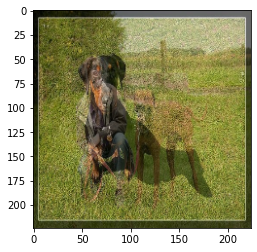

In [16]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, 120)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, 120)
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### onehot

In [18]:
def onehot(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape) == 0:
            label_a = tf.one_hot(label_a, num_classes)
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)
    
    onehot_imgs = tf.reshape(tf.stack(onehot_imgs), (batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels), (batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, with_onehot=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    if not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    if is_test and with_onehot:
        ds = ds.map(onehot, num_parallel_calls=2)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_onehot = apply_normalize_on_dataset(ds_test, is_test=True, with_onehot=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [22]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [23]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [24]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [25]:
ds_test_onehot

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

## 2. 모델 만들기
---
- ResNet-50을 사용해 비교실험을 위한 모델 두개 만들기

In [26]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [28]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기
---
- cutmix와 mixup은 sparse_categorical_crossentropy() 대신 categorical_crossentropy() 사용!

### 바닐라

In [30]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [31]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:02 - loss: 4.9404 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0587s vs `on_train_batch_end` time: 0.1078s). Check your callbacks.


750/750 [==============================] - 120s 160ms/step - loss: 2.2024 - accuracy: 0.4441 - val_loss: 3.5687 - val_accuracy: 0.1806
Epoch 2/20
750/750 [==============================] - 120s 160ms/step - loss: 0.7664 - accuracy: 0.7838 - val_loss: 1.3627 - val_accuracy: 0.6146
Epoch 3/20
750/750 [==============================] - 119s 158ms/step - loss: 0.3035 - accuracy: 0.9285 - val_loss: 1.0875 - val_accuracy: 0.6953
Epoch 4/20
750/750 [==============================] - 116s 155ms/step - loss: 0.1208 - accuracy: 0.9812 - val_loss: 1.0055 - val_accuracy: 0.7122
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0496 - accuracy: 0.9958 - val_loss: 0.9213 - val_accuracy: 0.7450
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 0.0312 - accuracy: 0.9977 - val_loss: 0.9384 - val_accuracy: 0.7385
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0204 - accuracy: 0.9987 - val_loss: 0.9406 - val_accura

### 기본 Aug

In [32]:
resnet50_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [33]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:24 - loss: 5.3818 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0551s vs `on_train_batch_end` time: 0.0854s). Check your callbacks.


750/750 [==============================] - 111s 148ms/step - loss: 2.2404 - accuracy: 0.4378 - val_loss: 2.7239 - val_accuracy: 0.3017
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 0.9558 - accuracy: 0.7222 - val_loss: 1.3069 - val_accuracy: 0.6219
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 0.5470 - accuracy: 0.8440 - val_loss: 1.1249 - val_accuracy: 0.6790
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 0.3029 - accuracy: 0.9207 - val_loss: 1.0984 - val_accuracy: 0.6905
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 0.1856 - accuracy: 0.9579 - val_loss: 1.0456 - val_accuracy: 0.7052
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 0.1154 - accuracy: 0.9781 - val_loss: 0.9931 - val_accuracy: 0.7261
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0869 - accuracy: 0.9842 - val_loss: 0.9839 - val_accura

### CutMix

In [34]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [35]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:24 - loss: 5.3164 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0489s vs `on_train_batch_end` time: 0.0818s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8236 - accuracy: 0.2127WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_test_batch_end` time: 0.0305s). Check your callbacks.


750/750 [==============================] - 117s 157ms/step - loss: 3.8236 - accuracy: 0.2127 - val_loss: 3.5839 - val_accuracy: 0.1873
Epoch 2/20
750/750 [==============================] - 124s 165ms/step - loss: 2.9503 - accuracy: 0.4328 - val_loss: 1.5345 - val_accuracy: 0.5911
Epoch 3/20
750/750 [==============================] - 121s 161ms/step - loss: 2.6240 - accuracy: 0.5227 - val_loss: 1.4198 - val_accuracy: 0.6038
Epoch 4/20
750/750 [==============================] - 121s 162ms/step - loss: 2.4499 - accuracy: 0.5864 - val_loss: 1.1931 - val_accuracy: 0.6672
Epoch 5/20
750/750 [==============================] - 122s 163ms/step - loss: 2.2871 - accuracy: 0.6421 - val_loss: 1.1985 - val_accuracy: 0.6714
Epoch 6/20
750/750 [==============================] - 121s 161ms/step - loss: 2.1676 - accuracy: 0.6725 - val_loss: 1.3237 - val_accuracy: 0.6465
Epoch 7/20
750/750 [==============================] - 122s 163ms/step - loss: 2.0976 - accuracy: 0.6998 - val_loss: 1.4107 - val_accura

### mixup

In [36]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [37]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:23 - loss: 4.9390 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0512s vs `on_train_batch_end` time: 0.0803s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7352 - accuracy: 0.2396WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0067s vs `on_test_batch_end` time: 0.0299s). Check your callbacks.


750/750 [==============================] - 115s 154ms/step - loss: 3.7352 - accuracy: 0.2396 - val_loss: 3.7538 - val_accuracy: 0.1505
Epoch 2/20
750/750 [==============================] - 115s 153ms/step - loss: 2.8944 - accuracy: 0.4661 - val_loss: 1.6047 - val_accuracy: 0.5525
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 2.6295 - accuracy: 0.5701 - val_loss: 1.3787 - val_accuracy: 0.6069
Epoch 4/20
750/750 [==============================] - 120s 160ms/step - loss: 2.4343 - accuracy: 0.6366 - val_loss: 1.5271 - val_accuracy: 0.5782
Epoch 5/20
750/750 [==============================] - 119s 159ms/step - loss: 2.2880 - accuracy: 0.6900 - val_loss: 1.2630 - val_accuracy: 0.6490
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 2.2011 - accuracy: 0.7254 - val_loss: 1.2815 - val_accuracy: 0.6469
Epoch 7/20
750/750 [==============================] - 122s 162ms/step - loss: 2.1437 - accuracy: 0.7489 - val_loss: 1.1640 - val_accura

## 4. 훈련 과정 시각화하고 비교하기
---

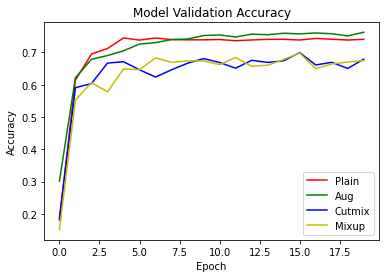

In [38]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'Cutmix', 'Mixup'])
plt.show()

### Report

- Augmentation을 추가했을 때 매우 미미한 성능 개선이 있었다.
- Cutmix와 Mixup의 경우 오히려 정확도가 떨어지는 것을 볼 수 있다.
- 원본 이미지 데이터에 cutmix, mixup 이미지를 추가한 것이 아니라 cutmix, mixup 이미지만 사용해서 오히려 정확도가 떨어진 것으로 보인다.
    - 즉 원본 데이터가 왜곡되었다
- 기본 Augmentation의 경우에는 변형된 이미지가 원본과 크게 다르지 않기 때문에 정확도가 큰 차이가 없었던 것으로 추측된다.
    - 즉 원본 데이터가 크게 왜곡되지는 않았다
- 원본 데이터를 추가해서 학습시켜보고 싶지만, 학습 시간이 너무 오래 걸리므로 포기
    